# Generate Data

In [38]:
%%capture
#generate simulated CMB maps, take few minutes
from lensing_sim import  CMBDataGenerator
r = 0.1
generator = CMBDataGenerator()
maps = generator.generate_maps(r, 80)

Q lensed map shape: torch.Size([48, 224, 224])
U lensed map shape: torch.Size([48, 224, 224])
B unlensed map shape: torch.Size([48, 224, 224])
B lensed map shape: torch.Size([48, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

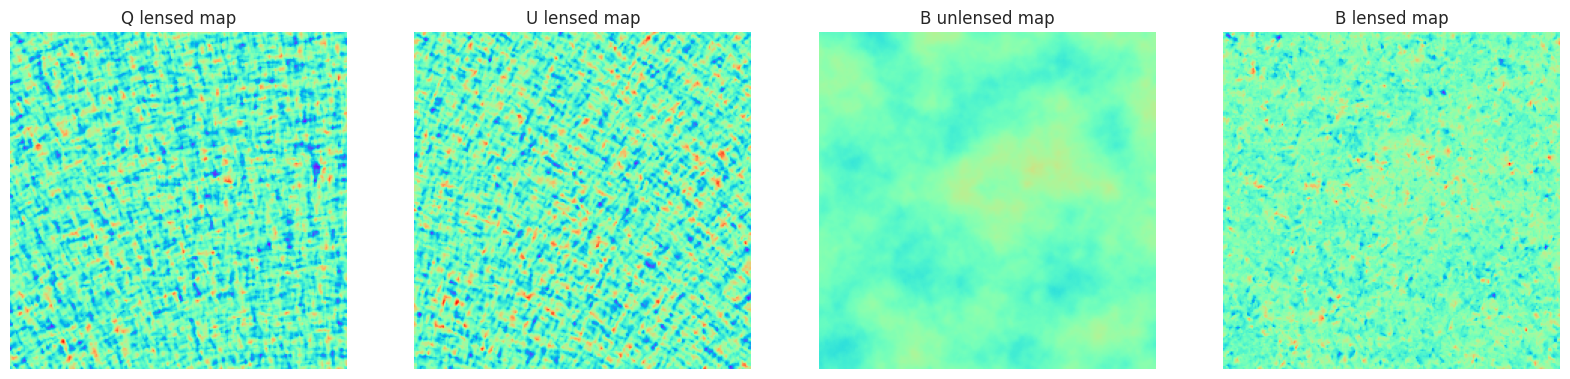

In [43]:
print('Q lensed map shape:', maps[0].shape)
print('U lensed map shape:', maps[1].shape)
print('B unlensed map shape:', maps[2].shape)
print('B lensed map shape:', maps[3].shape)
# maps[0].shape
import matplotlib.pyplot as plt
import numpy as np
import torch

# Plot the lensed and unlensed maps
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
idx = 0
axs[0].imshow(maps[0][idx], cmap='rainbow')
axs[0].set_title('Q lensed map')
axs[1].imshow(maps[1][idx], cmap='rainbow')
axs[1].set_title('U lensed map')
axs[2].imshow(maps[2][idx], cmap='rainbow',vmin=-1.1,vmax=1.1)
axs[2].set_title('B unlensed map')
axs[3].imshow(maps[3][idx], cmap='rainbow')
axs[3].set_title('B lensed map')

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')

# Delensing

In [34]:
import torch

import os
import numpy as np
import torch
from torch.distributions.uniform import Uniform
from model.swin_unet import SwinTransformerSys
import matplotlib.pyplot as plt
from utils import torch_ps,str2r
import torchvision.transforms as transforms

device = 'cuda'
weight = 'ABCMB_v1.pt'

check_point = torch.load('weight/'+weight,map_location=torch.device('cpu'))
model = SwinTransformerSys(skip_connect=True, drop_rate=0.0, attn_drop_rate=0.0, Fourier=False, last_bias=True, VAE=True, latent_dim=100)
model.load_state_dict(check_point["model_state_dict"],)
model = model.to(device)


/tmp/ipykernel_25450/714594439.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load('weight/'+weight,map_location=torch.device('cpu'))


---final upsample expand_first---


In [35]:
%%capture
from model.resunet import ResUnet
deepcmb = ResUnet()
weight_name = 'weight/deepcmb.pt'
checkpoint = torch.load(weight_name, map_location="cuda")
deepcmb.load_state_dict(checkpoint["model_state_dict"])
deepcmb = deepcmb.to(device)
deepcmb.eval()
model.eval()

In [36]:
import seaborn as sns
from tqdm import tqdm
true_ps = []
pred_ps = []
deepcmb_ps = []
qe_ps = []
lensed_ps = []
exp_true_ps = []
exp_pred_ps = []
exp_deepcmb_ps = []
exp_qe_ps = []
exp_lensed_ps = []
r = 0.1

data = torch.load('output/inference_map/all_map/r = 0.1000<start>160_sqdeg_224x224_pix_80.pt')
# 
for i in tqdm(range(48)):
    with torch.no_grad():
        Q_U = data[0:2,i].unsqueeze(dim=0).to(torch.float32).to(device)
        out = model(Q_U)
        # print(next(model.parameters()))
        true = data[2,i]
        lensed = data[3,i]
        pred = out[0]
        transform = transforms.CenterCrop(180)
        y = transform(true)
        lensed = transform(lensed)
        y_hat = transform(pred).squeeze()
        y_deepcmb = transform(deepcmb(Q_U).squeeze())
        qe_unlense = np.loadtxt(f'output/qe_delense/Bunlen_patch_<start>160_sqdeg_224x224_pix_patch_{i}_2.txt')
        y_qe_unlense = transform(torch.from_numpy(qe_unlense))
        true_ps.append(torch_ps(y,torch.device('cpu')).log().squeeze()[:20])
        pred_ps.append(torch_ps(y_hat.cpu(),torch.device('cpu')).log().squeeze()[:20])
        deepcmb_ps.append(torch_ps(y_deepcmb.cpu(),torch.device('cpu')).log().squeeze()[0:20])
        qe_ps.append(torch_ps(y_qe_unlense,torch.device('cpu')).log().squeeze()[:20])
        lensed_ps.append(torch_ps(lensed,torch.device('cpu')).log().squeeze()[:20])
        exp_true_ps.append(torch_ps(y,torch.device('cpu')).squeeze()[:20])
        exp_pred_ps.append(torch_ps(y_hat.cpu(),torch.device('cpu')).squeeze()[:20])
        exp_deepcmb_ps.append(torch_ps(y_deepcmb.cpu(),torch.device('cpu')).squeeze()[0:20])
        exp_qe_ps.append(torch_ps(y_qe_unlense,torch.device('cpu')).squeeze()[:20])
        exp_lensed_ps.append(torch_ps(lensed,torch.device('cpu')).squeeze()[:20])


/tmp/ipykernel_25450/193342737.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('output/inference_map/all_map/r = 0.1000<start>160_sqdeg_224x224_pix_80

100%|██████████| 48/48 [00:03<00:00, 14.94it/s]


Text(0.5, 1.0, '$r = 0.1$')

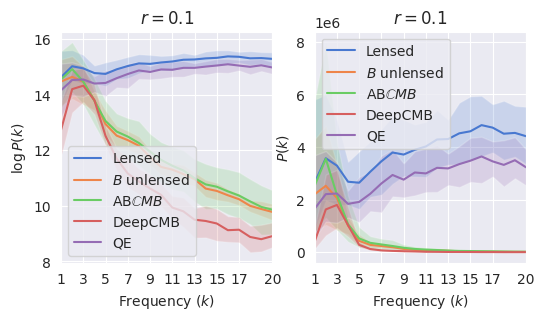

In [37]:
true_ps_mean = torch.stack(true_ps).squeeze().mean(dim =0)
pred_ps_mean = torch.stack(pred_ps).squeeze().mean(dim =0)
deepcmb_ps_mean = torch.stack(deepcmb_ps).squeeze().mean(dim =0)
qe_ps_mean = torch.stack(qe_ps).squeeze().mean(dim =0)
lensed_ps_mean = torch.stack(lensed_ps).squeeze().mean(dim =0)
true_ps_low_quantile = torch.quantile(torch.stack(true_ps).squeeze(),q=0.05,dim =0)
true_ps_high_quantile = torch.quantile(torch.stack(true_ps).squeeze(),q=0.95,dim =0)
pred_ps_low_quantile = torch.quantile(torch.stack(pred_ps).squeeze(),0.05,dim =0)
pred_ps_high_quantile = torch.quantile(torch.stack(pred_ps).squeeze(),0.95,dim =0)
deepcmb_ps_low_quantile = torch.quantile(torch.stack(deepcmb_ps).squeeze(),0.05,dim =0)
deepcmb_ps_high_quantile = torch.quantile(torch.stack(deepcmb_ps).squeeze(),0.95,dim =0)
qe_ps_low_quantile = torch.quantile(torch.stack(qe_ps).squeeze(),0.05,dim =0)
qe_ps_high_quantile = torch.quantile(torch.stack(qe_ps).squeeze(),0.95,dim =0)
lensed_ps_low_quantile = torch.quantile(torch.stack(lensed_ps).squeeze(),0.05,dim =0)
lensed_ps_high_quantile = torch.quantile(torch.stack(lensed_ps).squeeze(),0.95,dim =0)

sns.set_palette('muted')
sns.set_style('darkgrid')
frequency = np.arange(1, 21)
# Create figure and axis objects
fig, ax = plt.subplots(1,2,figsize=(6, 3))
sns.lineplot(x = frequency,y=lensed_ps_mean, ax=ax[0], label='Lensed')
ax[0].fill_between(frequency, lensed_ps_low_quantile, lensed_ps_high_quantile, alpha=0.2)
sns.lineplot(x = frequency,y=true_ps_mean, ax=ax[0], label=r'$B$ unlensed')
ax[0].fill_between(frequency, true_ps_low_quantile, true_ps_high_quantile, alpha=0.2)
# Plot the mean and standard deviation for the predicted power spectra
sns.lineplot(x = frequency,y=pred_ps_mean, ax=ax[0], label=r'AB$\mathbb{C}MB$')
ax[0].fill_between(frequency, pred_ps_low_quantile, pred_ps_high_quantile, alpha=0.2)
sns.lineplot(x = frequency,y=deepcmb_ps_mean, ax=ax[0], label='DeepCMB')
ax[0].fill_between(frequency, deepcmb_ps_low_quantile, deepcmb_ps_high_quantile, alpha=0.2)
sns.lineplot(x = frequency,y=qe_ps_mean, ax=ax[0], label='QE')
ax[0].fill_between(frequency, qe_ps_low_quantile, qe_ps_high_quantile, alpha=0.2)


ax[0].set_xlabel(r'Frequency ($k$)')
# ax.set_ylabel(r'$\log P(k)$')
ax[0].set_ylabel(r'$\log P(k)$')

# Set the x-axis limits and integer ticks
ax[0].set_xlim(1, 20)
# ax.set_xlim(1, 20)  # Change the x-axis limits to start at 1 instead of 0
ax[0].set_xticks(list(range(1, 19,2))+[20])  # Change the x-axis ticks to go from 1 to 20

# ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax[0].legend()
ax[0].set_title(f'$r = {r}$')
# plt.savefig(f'qe_delense/ps_model2_r=0.1_with_lensed_nonlog.png',dpi=200,bbox_inches='tight')


lensed_exp_ps_mean = torch.stack(exp_lensed_ps).squeeze().mean(dim =0)
true_exp_ps_mean = torch.stack(exp_true_ps).squeeze().mean(dim =0)
pred_exp_ps_mean = torch.stack(exp_pred_ps).squeeze().mean(dim =0)
deepcmb_exp_ps_mean = torch.stack(exp_deepcmb_ps).squeeze().mean(dim =0)
qe_exp_ps_mean = torch.stack(exp_qe_ps).squeeze().mean(dim =0)
lensed_exp_ps_low_quantile = torch.quantile(torch.stack(exp_lensed_ps).squeeze(),q=0.05,dim =0)
lensed_exp_ps_high_quantile = torch.quantile(torch.stack(exp_lensed_ps).squeeze(),q=0.95,dim =0)

true_exp_ps_low_quantile = torch.quantile(torch.stack(exp_true_ps).squeeze(),q=0.05,dim =0)
true_exp_ps_high_quantile = torch.quantile(torch.stack(exp_true_ps).squeeze(),q=0.95,dim =0)

pred_exp_ps_low_quantile = torch.quantile(torch.stack(exp_pred_ps).squeeze(),0.05,dim =0)
pred_exp_ps_high_quantile = torch.quantile(torch.stack(exp_pred_ps).squeeze(),0.95,dim =0)
deepcmb_exp_ps_low_quantile = torch.quantile(torch.stack(exp_deepcmb_ps).squeeze(),0.05,dim =0)
deepcmb_exp_ps_high_quantile = torch.quantile(torch.stack(exp_deepcmb_ps).squeeze(),0.95,dim =0)
qe_exp_ps_low_quantile = torch.quantile(torch.stack(exp_qe_ps).squeeze(),0.05,dim =0)
qe_exp_ps_high_quantile = torch.quantile(torch.stack(exp_qe_ps).squeeze(),0.95,dim =0)

sns.set_palette('muted')
sns.set_style('darkgrid')
frequency = np.arange(1, 21)
# Create figure and axis objects
sns.lineplot(x = frequency,y=lensed_exp_ps_mean, ax=ax[1], label='Lensed')
ax[1].fill_between(frequency, lensed_exp_ps_low_quantile, lensed_exp_ps_high_quantile, alpha=0.2)
sns.lineplot(x = frequency,y=true_exp_ps_mean, ax=ax[1], label=r'$B$ unlensed')
ax[1].fill_between(frequency, true_exp_ps_low_quantile, true_exp_ps_high_quantile, alpha=0.2)
# # Plot the mean and standard deviation for the predicted power spectra
sns.lineplot(x = frequency,y=pred_exp_ps_mean, ax=ax[1], label=r'AB$\mathbb{C}MB$')
ax[1].fill_between(frequency, pred_exp_ps_low_quantile, pred_exp_ps_high_quantile, alpha=0.2)
sns.lineplot(x = frequency,y=deepcmb_exp_ps_mean, ax=ax[1], label='DeepCMB')
ax[1].fill_between(frequency, deepcmb_exp_ps_low_quantile, deepcmb_exp_ps_high_quantile, alpha=0.2)
sns.lineplot(x = frequency,y=qe_exp_ps_mean, ax=ax[1], label='QE')
ax[1].fill_between(frequency, qe_exp_ps_low_quantile, qe_exp_ps_high_quantile, alpha=0.2)

ax[1].set_xlabel(r'Frequency ($k$)')
# ax.set_ylabel(r'$\log P(k)$')
ax[1].set_ylabel(r'$P(k)$')

# Set the x-axis limits and integer ticks
ax[1].set_xlim(1, 20)
# ax.set_xlim(1, 20)  # Change the x-axis limits to start at 1 instead of 0
ax[1].set_xticks(list(range(1, 19,2))+[20])  # Change the x-axis ticks to go from 1 to 20

# ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax[1].legend()
ax[1].set_title(f'$r = {r}$')
